In [1]:
# IMPORTING PACKAGES

import pandas as pd # working with data
import numpy as np # working with arrays
import matplotlib.pyplot as plt # visualization
import seaborn as sb # visualization
from mpl_toolkits.mplot3d import Axes3D # 3d plot
from termcolor import colored as cl # text customization

from sklearn.preprocessing import StandardScaler # data normalization
from sklearn.cluster import KMeans # K-means algorithm

plt.rcParams['figure.figsize'] = (20, 10)
sb.set_style('whitegrid')

from prince import FAMD
from sklearn.datasets import make_blobs
from kmodes.kprototypes import KPrototypes
random_state = 1234
pd.options.plotting.backend = "plotly"

In [2]:
# IMPORTING DATA
df=pd.read_excel("Mortgage Insurance Cross Sell - Dataset.xls")
df.set_index('Ref', inplace = True)
df.head()

,Credit_Score,Final_Grade,Term,Net_Advance,APR,Loan_Type,Mosaic,Mosaic_Class,Time_at_Address,Residential_Status,...,CIFAS_detected,Time_since_most_recent_outstandi,Insurance_Description,PPI,code,prdt_desc,category,PPI_SINGLE,PPI_JOINT,PPI_LCI
Ref,,,,,,,,,,,,,,,,,,,,,
1,918,A,36,3000.0,14.4,UnSecured,46,8,132,H,...,N,16,NaN,0,NaN,NaN,NaN,0,0,0
3,903,A,120,21000.0,7.9,secured,16,3,288,H,...,N,99,Life & Critical Illn,1,748.0,LIFE & CRITICAL ILLNESS,LCI,0,0,1
4,1060,X,78,7200.0,7.9,secured,17,3,276,H,...,N,50,Joint,1,719.0,LASCI JOINT,Joint,0,1,0
6,839,B,60,8000.0,16.9,UnSecured,47,8,48,R,...,N,99,Life & Critical Illn,1,748.0,LIFE & CRITICAL ILLNESS,LCI,0,0,1
7,1057,X,60,7650.0,7.4,UnSecured,55,10,156,H,...,N,99,Single,1,718.0,LASCI,Single,1,0,0


# EDA 

In [3]:
df.category.fillna('NULL',inplace=True)
df.category=df.category.apply(lambda x: x.upper())
df.category.value_counts(dropna=False)

NULL      6922
SINGLE    6264
LCI       1972
JOINT     1225
Name: category, dtype: int64

count    1.638300e+04
mean     7.821424e+04
std      8.942350e+04
min      0.000000e+00
25%      9.255500e+03
50%      5.943000e+04
75%      1.186560e+05
max      1.876225e+06
Name: Total_Outstanding_Balances, dtype: float64


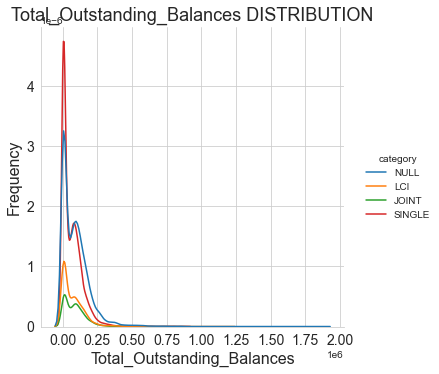

In [4]:
# Age distribution
var='Total_Outstanding_Balances'

print(cl(df[var].describe(), attrs = ['bold']))
sb.displot(data=df, x=var, hue='category', kind='kde')
plt.title(var+' DISTRIBUTION',fontsize = 18)
plt.xlabel(var,fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
# plt.legend(True)

plt.savefig(var+' distribution.png')
plt.show()

<AxesSubplot:xlabel='Loan_Type', ylabel='Count'>

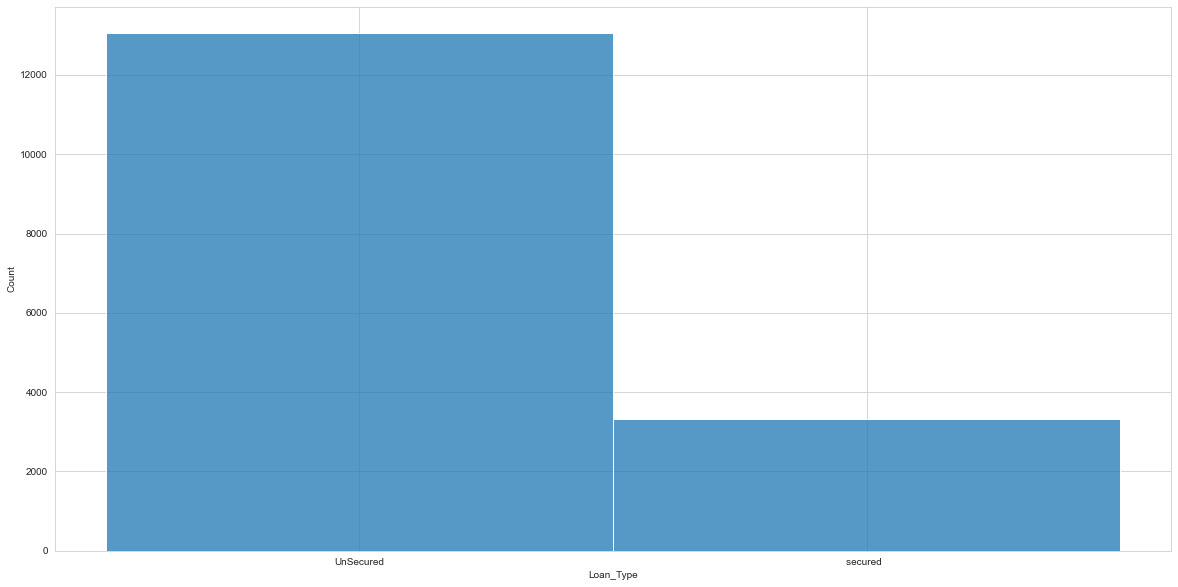

In [5]:
# df.Loan_Type
sb.histplot(x='Loan_Type',data=df)

# feature engg
    1. outliers treatment
    2. new feature creation
    3. feature selection based on EDA

In [6]:
df['F_C_mon_left_with_bank']=round(df.Outstanding_Mortgage_Bal/((df.Value_of_Property-df.Net_Advance)/df.Term),0)


count    1.638300e+04
mean     7.821424e+04
std      8.942350e+04
min      0.000000e+00
25%      9.255500e+03
50%      5.943000e+04
75%      1.186560e+05
max      1.876225e+06
Name: Total_Outstanding_Balances, dtype: float64


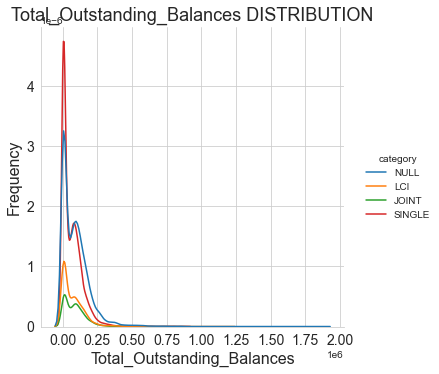

In [7]:
# Age distribution
var='Total_Outstanding_Balances'

print(cl(df[var].describe(), attrs = ['bold']))
sb.displot(data=df, x=var, hue='category', kind='kde')
plt.title(var+' DISTRIBUTION',fontsize = 18)
plt.xlabel(var,fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
# plt.legend(True)

plt.savefig(var+' distribution.png')
plt.show()

# Outlier treatment

# Flooring
    # Age
    # Total_outstanding_balance__mortg
    # Years_on_ER_for_SP
    # Total_outstanding_balance___excl
    # F_C_mon_left_with_bank


In [8]:
df.Total_outstanding_balance__mortg=df.Total_outstanding_balance__mortg.apply(lambda x: 0 if x<= 0 else x)
df.Age=df.Age.apply(lambda x: 0 if x<= 0 else x)
df.Years_on_ER_for_SP=df.Years_on_ER_for_SP.apply(lambda x: 0 if x<= 0 else x)
df.Total_outstanding_balance___excl=df.Total_outstanding_balance___excl.apply(lambda x: 0 if x<= 0 else x)
df.F_C_mon_left_with_bank=df.F_C_mon_left_with_bank.apply(lambda x: 0 if x<= 0 else x)

# Capping
    # Total_Outstanding_Balances
    # Bureau_Data___Monthly_Other_Co_R
    # F_C_mon_left_with_bank


In [9]:
df.Total_Outstanding_Balances=df.Total_Outstanding_Balances.apply(lambda x: 118656 if x>= 118656 else x)
df.Bureau_Data___Monthly_Other_Co_R=df.Bureau_Data___Monthly_Other_Co_R.apply(lambda x: 893 if x>= 893 else x)
df.F_C_mon_left_with_bank=df.F_C_mon_left_with_bank.apply(lambda x: 46 if x>= 46 else x)

In [10]:
cat_feature=['Cheque_Guarantee',
    'ACCESS_Card',
    'Other_Credit_Store_Card',
    'VISA_Card',
    'Loan_Type',
    'Telephone_Indicator',
    'Gender',
    'Residential_Status',
    'Marital_Status',
    'Employment_Status',
    'Final_Grade',
    'Income_Range',
    'Total___of_accounts',
    'Worst_History_CT',
    'Mosaic_Class']
cont_feature=['Age',
            'Total_outstanding_balance__mortg',
            'Years_on_ER_for_SP',
            'Total_outstanding_balance___excl',
            'Total_Outstanding_Balances',
            'Bureau_Data___Monthly_Other_Co_R',
            'Time_in_Employment',
            'Credit_Score',
            'Time_with_Bank',
            # 'Term',
            # 'Net_Advance',
            'APR',
            # 'Value_of_Property',
            # 'Outstanding_Mortgage_Bal',
            'F_C_mon_left_with_bank',
            'Searches___Total___L6m',
            # 'Mosaic',
            'Time_at_Address']

In [11]:
df[cat_feature].info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16383 entries, 1 to 42072
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Cheque_Guarantee         16383 non-null  object
 1   ACCESS_Card              16383 non-null  object
 2   Other_Credit_Store_Card  16383 non-null  object
 3   VISA_Card                16383 non-null  object
 4   Loan_Type                16383 non-null  object
 5   Telephone_Indicator      16383 non-null  object
 6   Gender                   16383 non-null  object
 7   Residential_Status       16383 non-null  object
 8   Marital_Status           16383 non-null  object
 9   Employment_Status        16383 non-null  object
 10  Final_Grade              16383 non-null  object
 11  Income_Range             16383 non-null  int64 
 12  Total___of_accounts      16383 non-null  int64 
 13  Worst_History_CT         16383 non-null  int64 
 14  Mosaic_Class             16383 non-nul

In [12]:
df.Worst_History_CT=df.Worst_History_CT.apply(lambda x: str(x))
df.Mosaic_Class=df.Mosaic_Class.apply(lambda x: str(x))
df.Income_Range=df.Income_Range.apply(lambda x: str(x))
df.Total___of_accounts=df.Total___of_accounts.apply(lambda x: str(x))

## converting the cat features to numeric using dummies

In [13]:
df_cat=pd.get_dummies(df[cat_feature])
df_cat=df_cat.reset_index()
df_cat.head()

,Ref,Cheque_Guarantee_FALS,Cheque_Guarantee_TRUE,ACCESS_Card_FALSE,ACCESS_Card_TRUE,Other_Credit_Store_Card_FALSE,Other_Credit_Store_Card_TRUE,VISA_Card_FALSE,VISA_Card_TRUE,Loan_Type_UnSecured,...,Mosaic_Class_11,Mosaic_Class_2,Mosaic_Class_3,Mosaic_Class_4,Mosaic_Class_5,Mosaic_Class_6,Mosaic_Class_7,Mosaic_Class_8,Mosaic_Class_9,Mosaic_Class_99
0,1,0,1,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0
1,3,0,1,1,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,4,0,1,1,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,6,0,1,1,0,1,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
4,7,0,1,0,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


## normalization of the contineous features 

In [14]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
names = cont_feature
d = scaler.fit_transform(df[cont_feature])
df_cont = pd.DataFrame(d, columns=names)

print(df_cont.shape)
df_cont.head()

(16383, 13)


,Age,Total_outstanding_balance__mortg,Years_on_ER_for_SP,Total_outstanding_balance___excl,Total_Outstanding_Balances,Bureau_Data___Monthly_Other_Co_R,Time_in_Employment,Credit_Score,Time_with_Bank,APR,F_C_mon_left_with_bank,Searches___Total___L6m,Time_at_Address
0,0.597403,0.064064,0.294118,0.018018,0.542796,0.574468,0.480000,0.600212,0.222222,0.285714,0.217391,1.000000,0.151796
1,0.766234,0.013013,0.647059,0.203203,0.266434,0.370661,0.061667,0.584305,0.396825,0.156746,0.195652,0.666667,0.332561
2,0.727273,0.019019,0.617647,0.087087,0.219500,0.462486,0.256667,0.750795,0.488095,0.156746,0.152174,0.111111,0.318656
3,0.428571,0.160160,0.000000,0.229229,1.000000,1.000000,0.136667,0.516437,0.285714,0.335317,0.000000,0.555556,0.054461
4,0.636364,0.062062,0.382353,0.038038,0.537781,0.487122,0.570000,0.747614,0.674603,0.146825,0.456522,0.111111,0.179606


In [15]:
df_final=pd.concat([df_cat,df_cont], axis=1)
print(df_final.shape)
df_final.set_index('Ref',inplace=True)
df_final.head()

(16383, 92)


,Cheque_Guarantee_FALS,Cheque_Guarantee_TRUE,ACCESS_Card_FALSE,ACCESS_Card_TRUE,Other_Credit_Store_Card_FALSE,Other_Credit_Store_Card_TRUE,VISA_Card_FALSE,VISA_Card_TRUE,Loan_Type_UnSecured,Loan_Type_secured,...,Total_outstanding_balance___excl,Total_Outstanding_Balances,Bureau_Data___Monthly_Other_Co_R,Time_in_Employment,Credit_Score,Time_with_Bank,APR,F_C_mon_left_with_bank,Searches___Total___L6m,Time_at_Address
Ref,,,,,,,,,,,,,,,,,,,,,
1,0,1,1,0,0,1,1,0,1,0,...,0.018018,0.542796,0.574468,0.480000,0.600212,0.222222,0.285714,0.217391,1.000000,0.151796
3,0,1,1,0,1,0,0,1,0,1,...,0.203203,0.266434,0.370661,0.061667,0.584305,0.396825,0.156746,0.195652,0.666667,0.332561
4,0,1,1,0,1,0,0,1,0,1,...,0.087087,0.219500,0.462486,0.256667,0.750795,0.488095,0.156746,0.152174,0.111111,0.318656
6,0,1,1,0,1,0,0,1,1,0,...,0.229229,1.000000,1.000000,0.136667,0.516437,0.285714,0.335317,0.000000,0.555556,0.054461
7,0,1,0,1,1,0,1,0,1,0,...,0.038038,0.537781,0.487122,0.570000,0.747614,0.674603,0.146825,0.456522,0.111111,0.179606


In [16]:
# DATA PROCESSING

X = df_final.values
X = np.nan_to_num(X)

sc = StandardScaler()
cluster_data = sc.fit_transform(X)
print(cl('Cluster data samples : ', attrs = ['bold']), cluster_data)

Cluster data samples :  [[-0.34293867  0.34293867  0.50746651 ... -0.64699275  2.53638153
   0.10543084]
 [-0.34293867  0.34293867  0.50746651 ... -0.69934229  1.28535926
   1.53414811]
 [-0.34293867  0.34293867  0.50746651 ... -0.80404137 -0.79967785
   1.42424678]
 ...
 [-0.34293867  0.34293867 -1.97057338 ...  0.24294941 -0.79967785
  -0.67303691]
 [-0.34293867  0.34293867 -1.97057338 ... -0.54229367 -0.38267043
   0.08711395]
 [-0.34293867  0.34293867  0.50746651 ...  1.23759064  0.034337
   0.54503615]]


# K-means assumption and precautions
    # Scale/standardize the data when applying kmeans algorithm.
    # Elbow method in selecting number of clusters doesn’t usually work because the error function is monotonically decreasing for all ks.
    # Kmeans gives more weight to the bigger clusters.
    # Kmeans assumes spherical shapes of clusters (with radius equal to the distance between the centroid and the furthest data point) and doesn’t work well when clusters are in different shapes such as elliptical clusters.
    # If there is overlapping between clusters, kmeans doesn’t have an intrinsic measure for uncertainty for the examples belong to the overlapping region in order to determine for which cluster to assign each data point.
    # Kmeans may still cluster the data even if it can’t be clustered such as data that comes from uniform distributions

In [47]:
wcss=[]
for i in range(1,30):
    kmeans = KMeans(i,init='k-means++')
    kmeans.fit(X)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)


number_clusters = range(1,30)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

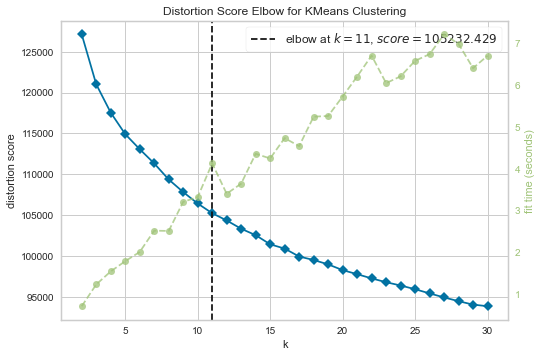

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans(init='k-means++')
visualizer = KElbowVisualizer(model, k=30)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()  

In [22]:
# MODELING

clusters = 11
model = KMeans(init='k-means++',n_clusters = clusters)
model.fit(X)

labels = model.labels_
print(cl(labels[:100], attrs = ['bold']))

[ 1  3  4  1  6 10  6 10  6  7 10  3  1  7  1 10 10  1  7 10 10 10 10  8
  5  6  6  7  8  9 10 10 10  7  4 10  1  3  0  3 10 10  3  1  8  8  3  8
  6  4  6 10 10  6 10  8  7  9  1  3  7 10  2  8  2 10  9 10  8  8 10  7
  2  2  2  2  0  7  3  9  0  1  9  8  3  0  4  4  3  1  7  9  0  5  5  6
  9  1  9  8]


In [23]:
df['cluster_num'] = labels
df.head()

,Credit_Score,Final_Grade,Term,Net_Advance,APR,Loan_Type,Mosaic,Mosaic_Class,Time_at_Address,Residential_Status,...,Insurance_Description,PPI,code,prdt_desc,category,PPI_SINGLE,PPI_JOINT,PPI_LCI,F_C_mon_left_with_bank,cluster_num
Ref,,,,,,,,,,,,,,,,,,,,,
1,918,A,36,3000.0,14.4,UnSecured,46,8,132,H,...,NaN,0,NaN,NaN,NULL,0,0,0,10.0,1
3,903,A,120,21000.0,7.9,secured,16,3,288,H,...,Life & Critical Illn,1,748.0,LIFE & CRITICAL ILLNESS,LCI,0,0,1,9.0,3
4,1060,X,78,7200.0,7.9,secured,17,3,276,H,...,Joint,1,719.0,LASCI JOINT,JOINT,0,1,0,7.0,4
6,839,B,60,8000.0,16.9,UnSecured,47,8,48,R,...,Life & Critical Illn,1,748.0,LIFE & CRITICAL ILLNESS,LCI,0,0,1,0.0,1
7,1057,X,60,7650.0,7.4,UnSecured,55,10,156,H,...,Single,1,718.0,LASCI,SINGLE,1,0,0,21.0,6


In [24]:
pd.crosstab([df.cluster_num,df.PPI_SINGLE,df.PPI_JOINT,df.PPI_LCI],1).to_csv('test.csv')

# result summary based on numbers within each cluster max

In [25]:
cls_result=pd.DataFrame(pd.crosstab([df.cluster_num,df.PPI_SINGLE,df.PPI_JOINT,df.PPI_LCI],1)).reset_index()
def combine(row):
    if (row['PPI_SINGLE']==0) & (row['PPI_JOINT']==0) & (row['PPI_LCI']==0):
        return 'None'
    elif (row['PPI_SINGLE']==1) & (row['PPI_JOINT']==0) & (row['PPI_LCI']==0):
        return 'PPI_SINGLE'
    elif (row['PPI_SINGLE']==0) & (row['PPI_JOINT']==1) & (row['PPI_LCI']==0):
        return 'PPI_JOINT'
    else:
        return 'PPI_LCI'
cls_result['Summary']=cls_result.apply(combine,axis=1)
cls_result=cls_result.sort_values(by=['cluster_num',1])
cls_result.head()


col_0,cluster_num,PPI_SINGLE,PPI_JOINT,PPI_LCI,1,Summary
2,0,0,1,0,54,PPI_JOINT
1,0,0,0,1,160,PPI_LCI
0,0,0,0,0,620,None
3,0,1,0,0,640,PPI_SINGLE
5,1,0,0,1,198,PPI_LCI


In [26]:
a=cls_result.drop_duplicates(subset=['cluster_num'],keep='last')
a.Summary.value_counts(dropna=False)

None          6
PPI_SINGLE    5
Name: Summary, dtype: int64

# result summary based on % share of product under each cluster

In [27]:
cls_result=pd.DataFrame(pd.crosstab([df.cluster_num,df.PPI_SINGLE,df.PPI_JOINT,df.PPI_LCI],1)).reset_index()
print(cls_result.shape)

(43, 5)


In [28]:
cls_result.cluster_num.value_counts(dropna=False)==4

0      True
1      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
2     False
Name: cluster_num, dtype: bool

In [29]:
cls_result['Summary']=cls_result.apply(combine,axis=1)
cls_result.drop(columns=['PPI_SINGLE','PPI_JOINT','PPI_LCI'],inplace=True)


In [30]:
cls_result.rename(columns={1:'count'},inplace=True)
cls_result

col_0,cluster_num,count,Summary
0,0,620,None
1,0,160,PPI_LCI
2,0,54,PPI_JOINT
3,0,640,PPI_SINGLE
4,1,818,None
5,1,198,PPI_LCI
6,1,211,PPI_JOINT
7,1,616,PPI_SINGLE
8,2,553,None
9,2,3,PPI_LCI


In [31]:
def per_share(row):
    if (row['Summary']=='PPI_SINGLE'):
        return row['count']/6264
    elif (row['Summary']=='PPI_JOINT'):
        return row['count']/1225
    elif (row['Summary']=='PPI_LCI'):
        return row['count']/1972
    else:
        return row['count']/6922

In [32]:
cls_result['Per_share']=cls_result.apply(per_share,axis=1)
cls_result

col_0,cluster_num,count,Summary,Per_share
0,0,620,None,0.089569
1,0,160,PPI_LCI,0.081136
2,0,54,PPI_JOINT,0.044082
3,0,640,PPI_SINGLE,0.102171
4,1,818,None,0.118174
5,1,198,PPI_LCI,0.100406
6,1,211,PPI_JOINT,0.172245
7,1,616,PPI_SINGLE,0.098340
8,2,553,None,0.079890
9,2,3,PPI_LCI,0.001521


In [33]:
cls_result=cls_result.sort_values(by=['cluster_num','Per_share'])
cls_result.head()

col_0,cluster_num,count,Summary,Per_share
2,0,54,PPI_JOINT,0.044082
1,0,160,PPI_LCI,0.081136
0,0,620,None,0.089569
3,0,640,PPI_SINGLE,0.102171
7,1,616,PPI_SINGLE,0.098340


In [34]:
a=cls_result.drop_duplicates(subset=['cluster_num'],keep='last')
a.Summary.value_counts(dropna=False)

PPI_JOINT     5
None          3
PPI_SINGLE    2
PPI_LCI       1
Name: Summary, dtype: int64

In [35]:
pd.crosstab(a.Summary,a.cluster_num)

cluster_num,0,1,2,3,4,5,6,7,8,9,10
Summary,,,,,,,,,,,
None,0,0,1,0,1,0,1,0,0,0,0
PPI_JOINT,0,1,0,0,0,1,0,0,1,1,1
PPI_LCI,0,0,0,1,0,0,0,0,0,0,0
PPI_SINGLE,1,0,0,0,0,0,0,1,0,0,0


In [36]:
# None
df.loc[df['cluster_num'].isin([2,4,6]),:]['category'].value_counts(dropna=False)

NULL      1970
SINGLE     945
LCI        293
JOINT      179
Name: category, dtype: int64

In [37]:
# Single
df.loc[df['cluster_num'].isin([0,7]),:]['category'].value_counts(dropna=False)

SINGLE    1637
NULL      1061
LCI        349
JOINT      108
Name: category, dtype: int64

In [38]:
# joint
df.loc[df['cluster_num'].isin([1,5,8,9,10]),:]['category'].value_counts(dropna=False)

NULL      3227
SINGLE    2970
LCI       1039
JOINT      878
Name: category, dtype: int64

In [39]:
# lci
df.loc[df['cluster_num'].isin([3]),:]['category'].value_counts(dropna=False)

SINGLE    712
NULL      664
LCI       291
JOINT      60
Name: category, dtype: int64

In [43]:
df.groupby(by='cluster_num')['Age'].mean()

cluster_num
0     39.307327
1     43.875203
2     37.332836
3     43.023162
4     51.580579
5     46.333152
6     46.852964
7     36.273052
8     45.522303
9     48.271597
10    44.212083
Name: Age, dtype: float64

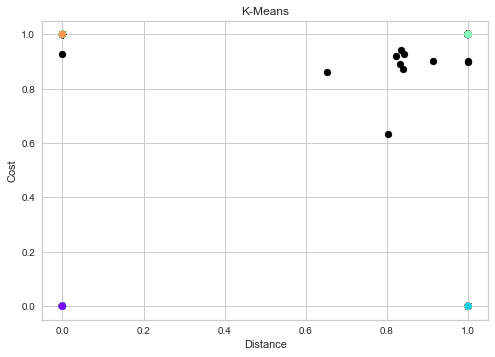

In [46]:
plt.scatter(X[:,2], X[:,1], c=model.labels_, cmap='rainbow')
plt.scatter(model.cluster_centers_[:,2] ,model.cluster_centers_[:,1], color = 'black')
plt.title('K-Means')
plt.xlabel('Distance')
plt.ylabel('Cost') 
plt.show()